<a href="https://colab.research.google.com/github/favourphilic/Deep-Learning/blob/main/NeuralNetwork_Classification_Using_The_MoonDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
For consistency, the dataset should have 1000 samples and a random_state=42.
Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

3. Setup a binary classification compatible loss function and optimizer to use when training the model.

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
Train the model for long enough for it to reach over 96% accuracy.
The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
Feel free to reference the ML cheatsheet website for the formula.

7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

## 1.0 Make a binary classification dataset with Scikit-Learn's make_moons() function.
* lets start by making two ibterleaving half circles using the make moon module of scikit learn
* The make moon module will help us create dataset that can be used for clutering or classification dataset.
* In short, a dataset that would reguired more just a linear fucntion to adequately seperate the clutsers of data points.

In [ ]:
#The code below will make 1000 interleaving half circles which are divided into two groups.

N = 1000  # Total number of sample
randomstate = 42 #Random_state

from sklearn.datasets import make_moons
X, y = make_moons(N, noise =0.04, random_state=randomstate) #adding the noise argument will add standard deviation gaussian noise to the data.

In [ ]:
#Lets take a look at few of the data points and labels
print(f"The first 5 values of the X variable are {X[:5]}")
print(f"The first five labels are {y[:5]}")

The first 5 values of the X variable are [[-0.01535155  0.39858357]
 [ 0.96563716 -0.46603945]
 [ 0.91129221 -0.400858  ]
 [ 0.39506559 -0.38671088]
 [-0.84362286  0.52969301]]
The first five labels are [1 1 1 1 0]


In [ ]:
#Making a DataFrame for the dataset
import pandas as pd
moons = pd.DataFrame({'X1':X[:, 0], 'X2':X[:,1], 'label':y})
moons.head() #Print the first 5 rows

,X1,X2,label
0,-0.015352,0.398584,1
1,0.965637,-0.466039,1
2,0.911292,-0.400858,1
3,0.395066,-0.386711,1
4,-0.843623,0.529693,0


In [ ]:
# Check the frequecy of the class label
moons.label.value_counts()

1    500
0    500
Name: label, dtype: int64

<Axes: xlabel='X1', ylabel='X2'>

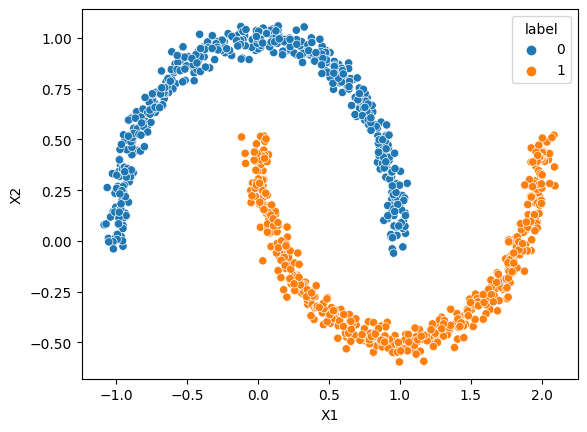

In [ ]:
#  Observing our data in tabular form is less informative comapred to a plot.
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data=moons, x='X1', y='X2', hue='label')

In [ ]:
# get the shape of the features and label data points, as this gives idea of how the data is aranged and help to avaoid shape problem in pytorch computation.
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
#get the shape of a single sample.
x_sample = X[0]
y_sample = y[0]

print(f"The first sample from the data is {x_sample} and the first label {y_sample}")
print(f"The shape of the first sample is {x_sample.shape} and the shape of the label is {y_sample.shape}")

The first sample from the data is [-0.01535155  0.39858357] and the first label 1
The shape of the first sample is (2,) and the shape of the label is ()


## 1b Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [ ]:
#Turn the data(Which is currently a Numpy array) into tensor(a data container preferred by PyTorch) using torch.from_numpy method
import torch # import torch library
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [ ]:
X[:5], y[:5]

(tensor([[-0.0154,  0.3986],
         [ 0.9656, -0.4660],
         [ 0.9113, -0.4009],
         [ 0.3951, -0.3867],
         [-0.8436,  0.5297]]),
 tensor([1., 1., 1., 1., 0.]))

In [ ]:
#Using the traintestsplit from sklearn library to split our dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # where testsize = 20%

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2.0 Build a model by subclassing nn.Module

* First, lets state the building block of our model.
  * We will set up a device agnostic code that can run on either the CPU or GPU(if its available for your device)
  * We will construct our model of choice by subclassing the nn.Module
  * We will intially create a baseline model, which will simply be a linear model( recall from the plot above that we don't require a linear model to solve this task. However, doing this will enable us compare the base model with other model structure, thus helping use to effect of  non-linear activation functions that is capable of fitting the data.)
  * After, this we can go ahead and create our loss function and optimizer of choice.
  * Last step will be to create a training loop.

In [ ]:
import torch
from torch import nn               # importing required library from PyTorch.

device ="cuda" if  torch.cuda.is_available() else "cpu"   # setting up a device agnostic model, this allow our code to run on either CPU or GPU(if available)
device


'cpu'

In [ ]:
# 1. Construct a model class that subclasses nn.Module
class MoonModelV0(nn.Module):        
    def __init__(self):
        super(MoonModelV0, self).__init__()
        
        self.layer_1 = nn.Linear(in_features=2, out_features=5) 
        self.layer_2 = nn.Linear(in_features=5, out_features=1) 
    
    
    def forward(self, x):    #the forward computation perfroms the prediction
        
        return self.layer_2(self.layer_1(x))  # passing the output of layer 1 into alyer2

# Creating an instance of the model and send it to target device
model_0 = MoonModelV0().to(device) #This model is a baseline model and do not contain any activation layer.
model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### 3.0 Setup a binary classification compatible loss function and optimizer to use when training the model.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss() # Creating a loss function with BCEWithLogitsLoss, which has  sigmoid built-in 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1) #creating an optimizer

In [ ]:
#!pip install torchmetrics

In [ ]:
#Lets create a function to get the accuracy of our model.
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [ ]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
# Note that we are yet to train the model
y_logits

tensor([[0.9393],
        [0.8340],
        [1.2143],
        [0.7526],
        [1.3572]], grad_fn=<SliceBackward0>)

### 4-5.0 Creating  a training and testing loop to fit the modelo we created above.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Set the model in Training state
    model_0.train()

    
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # # This line of code converts the raw output to probabilty and then label
  
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing state
    model_0.eval()
    with torch.inference_mode():
      
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.65875, Accuracy: 50.00% | Test loss: 0.66582, Test acc: 50.00%
Epoch: 10 | Loss: 0.58115, Accuracy: 70.25% | Test loss: 0.59476, Test acc: 68.50%
Epoch: 20 | Loss: 0.51675, Accuracy: 79.88% | Test loss: 0.53556, Test acc: 75.50%
Epoch: 30 | Loss: 0.46264, Accuracy: 80.50% | Test loss: 0.48537, Test acc: 77.00%
Epoch: 40 | Loss: 0.41960, Accuracy: 80.12% | Test loss: 0.44471, Test acc: 80.00%
Epoch: 50 | Loss: 0.38705, Accuracy: 80.62% | Test loss: 0.41306, Test acc: 80.00%
Epoch: 60 | Loss: 0.36294, Accuracy: 81.25% | Test loss: 0.38873, Test acc: 80.00%
Epoch: 70 | Loss: 0.34492, Accuracy: 82.12% | Test loss: 0.36981, Test acc: 81.50%
Epoch: 80 | Loss: 0.33109, Accuracy: 82.75% | Test loss: 0.35469, Test acc: 82.50%
Epoch: 90 | Loss: 0.32007, Accuracy: 83.12% | Test loss: 0.34223, Test acc: 82.00%


* Wow, we had  82% accuracy on the test data.
* It seems our model is doing pretty well in identifying patterns and classifiying our datapoints into group.
* However, recall that the dataset isnt linear and this is just a baseline model
* lets visualize the ability of the model to separate the datapoint points into different group.

### Visualize Visualize Visualize
* I will download helper_function from Deep Learning with PyTorch Repo.
* The function will allow us make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo 
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

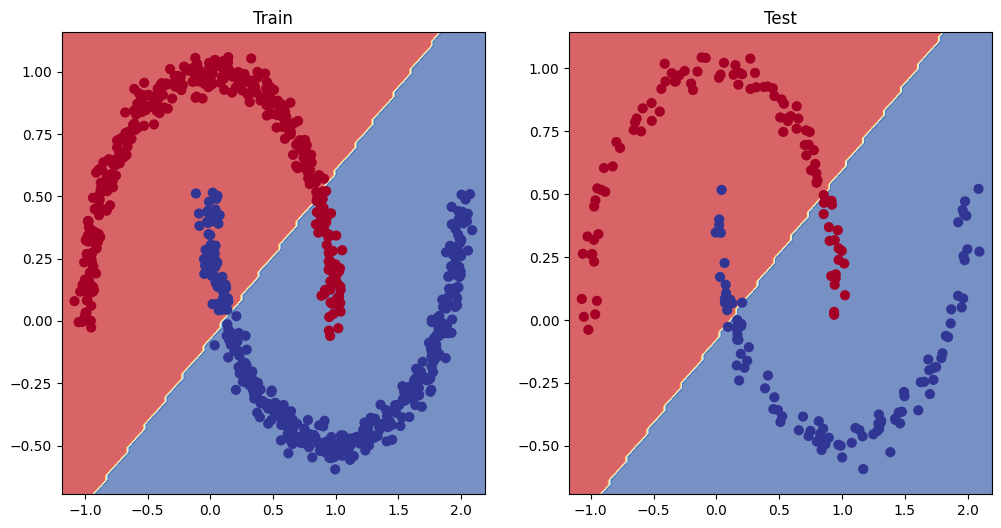

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

* The model is trying to split the data diagonally. However, few clutsers are still wrongly classified and this explains the 82% accuracy observed above.

## Improving the baseline model.
* Some the steps that can improve the baseline accuracy from 82% to above 90% include:
  * Adding more hidden layers or units.
  * Introducing non-linear activation fucntions.
  * We can aslo train for longer epoch.
  * Change the linear rate, loss function among others.

In [ ]:
# Build model with non-linear activation function
from torch import nn
class MoonModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- Here i introduce ReLU activation function

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = MoonModelV1().to(device)
print(model_1)

MoonModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
#Set the number of epochs
epochs = 1000
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Set the model in Training state
    model_1.train()

    
    y_logits = model_1(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # # This line of code converts the raw output to probabilty and then label
  
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing state
    model_1.eval()
    with torch.inference_mode():
      
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.00675, Accuracy: 100.00% | Test loss: 0.00542, Test acc: 100.00%
Epoch: 10 | Loss: 0.00667, Accuracy: 100.00% | Test loss: 0.00536, Test acc: 100.00%
Epoch: 20 | Loss: 0.00659, Accuracy: 100.00% | Test loss: 0.00530, Test acc: 100.00%
Epoch: 30 | Loss: 0.00652, Accuracy: 100.00% | Test loss: 0.00524, Test acc: 100.00%
Epoch: 40 | Loss: 0.00645, Accuracy: 100.00% | Test loss: 0.00518, Test acc: 100.00%
Epoch: 50 | Loss: 0.00638, Accuracy: 100.00% | Test loss: 0.00512, Test acc: 100.00%
Epoch: 60 | Loss: 0.00631, Accuracy: 100.00% | Test loss: 0.00506, Test acc: 100.00%
Epoch: 70 | Loss: 0.00624, Accuracy: 100.00% | Test loss: 0.00501, Test acc: 100.00%
Epoch: 80 | Loss: 0.00617, Accuracy: 100.00% | Test loss: 0.00495, Test acc: 100.00%
Epoch: 90 | Loss: 0.00611, Accuracy: 100.00% | Test loss: 0.00490, Test acc: 100.00%


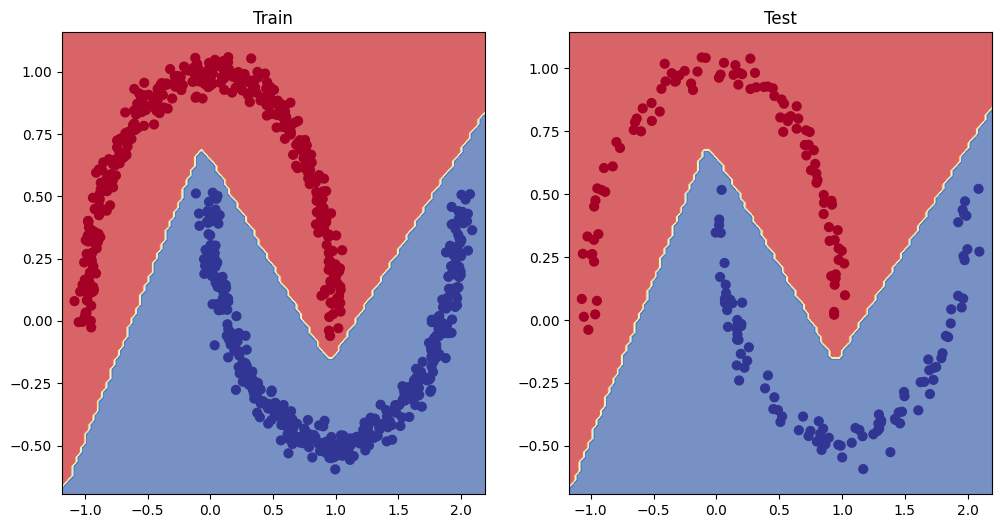

In [ ]:
# Plot decision boundaries for training and test sets using a non activation fucntion ReLU
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6.0 Replicate the Tanh (hyperbolic tangent) activation function. 

In [ ]:
# Build model with non-linear activation function (TanH)
from torch import nn
class MoonModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.tanh = nn.Tanh() # <- Here i introduce ReLU activation function

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.tanh(self.layer_2(self.tanh(self.layer_1(x)))))

model_2 = MoonModelV2().to(device)
print(model_2)

MoonModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (tanh): Tanh()
)


In [ ]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(42)
#Set the number of epochs
epochs = 1000
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Set the model in Training state
    model_2.train()

    
    y_logits = model_2(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # # This line of code converts the raw output to probabilty and then label
  
    loss = loss_fn(y_logits, y_train) 
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing state
    model_2.eval()
    with torch.inference_mode():
      
        test_logits = model_2(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70857, Accuracy: 50.00% | Test loss: 0.69918, Test acc: 50.00%
Epoch: 100 | Loss: 0.30884, Accuracy: 85.25% | Test loss: 0.32015, Test acc: 85.50%
Epoch: 200 | Loss: 0.25192, Accuracy: 89.00% | Test loss: 0.24892, Test acc: 89.50%
Epoch: 300 | Loss: 0.24207, Accuracy: 89.50% | Test loss: 0.23626, Test acc: 90.00%
Epoch: 400 | Loss: 0.22798, Accuracy: 89.88% | Test loss: 0.22096, Test acc: 91.00%
Epoch: 500 | Loss: 0.19525, Accuracy: 91.75% | Test loss: 0.18742, Test acc: 92.50%
Epoch: 600 | Loss: 0.13706, Accuracy: 94.38% | Test loss: 0.12978, Test acc: 94.50%
Epoch: 700 | Loss: 0.08224, Accuracy: 97.88% | Test loss: 0.07639, Test acc: 98.50%
Epoch: 800 | Loss: 0.05060, Accuracy: 99.62% | Test loss: 0.04597, Test acc: 100.00%
Epoch: 900 | Loss: 0.03416, Accuracy: 99.75% | Test loss: 0.03043, Test acc: 100.00%


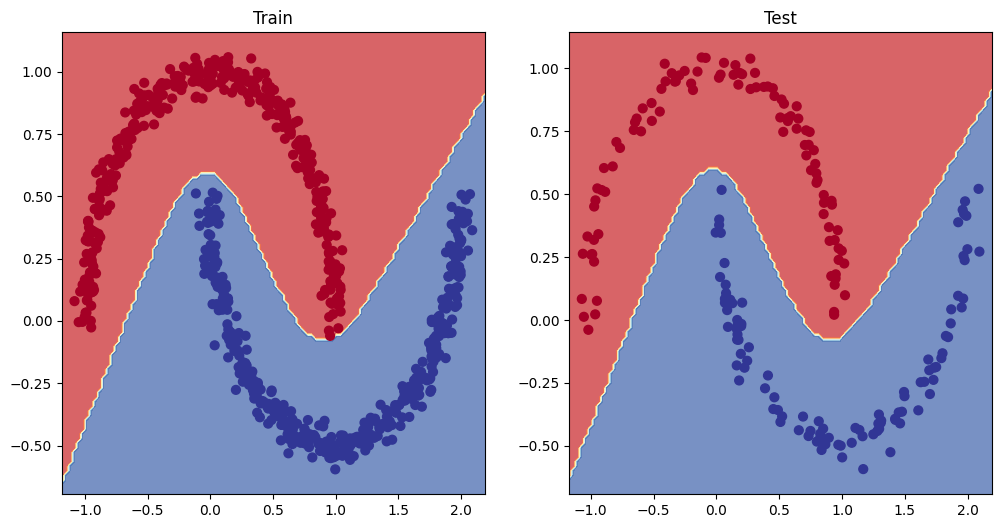

In [ ]:
# Plot decision boundaries for training and test sets using a non activation fucntion TanH
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)